# Titanic

In [1]:
# load the data
import pandas as pd

df = pd.read_csv('train.csv',index_col='PassengerId')
display(df.info())
display(df.head(10))
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Text(0,0.5,'Count')

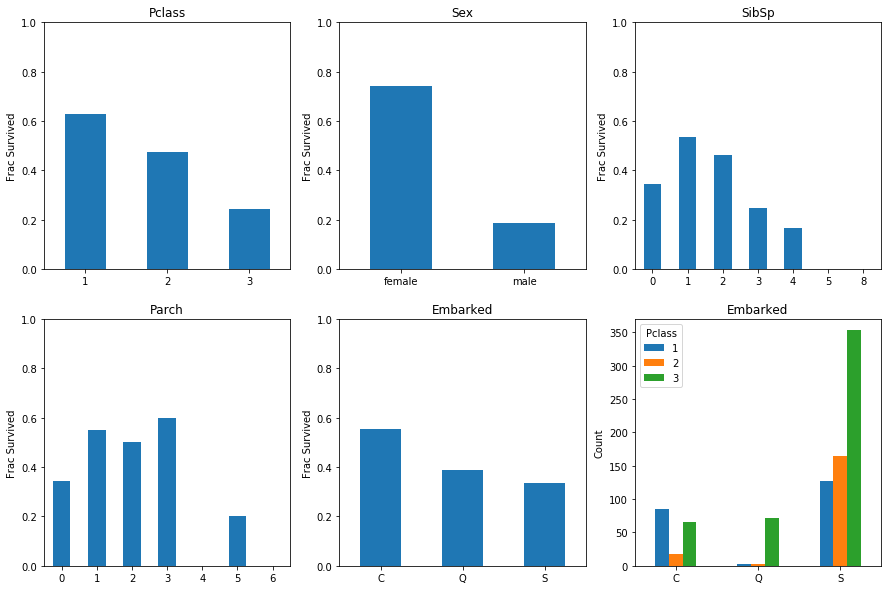

In [2]:
# few bar plots to get an idea of survival rate in some of the categories

import matplotlib.pyplot as plt
%matplotlib inline

def mean_survived(feature):
    return df.groupby(feature).Survived.mean()

plot_feats = ['Pclass','Sex','SibSp','Parch','Embarked']
plt.figure(figsize=(15,10))
figRows=2
figCols=3
i=1
for feature in plot_feats:
    ax=plt.subplot(2,3,i)
    mean_survived(feature).plot.bar(title=feature,ax=ax,rot=0)
    plt.xlabel('')
    plt.ylabel('Frac Survived')
    plt.ylim(0,1)
    i+=1

ax=plt.subplot(2,3,6)
df.groupby('Embarked')['Pclass'].value_counts().unstack().plot.bar(title='Embarked',ax=ax,rot=0)
plt.xlabel('')
plt.ylabel('Count') 

In [3]:
# replace couple missing Embarked values with S - most common port
df.Embarked.fillna('S',inplace=True)

Passengers with shared ticket but no parents,children,siblings or spouse onboard:  75


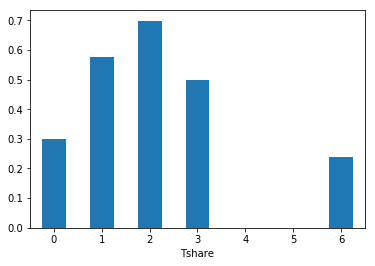

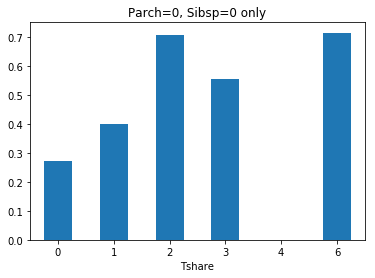

In [4]:
# add a column with number of people the passenger shares a ticket number with. Remove original Ticket column.
Tshare=pd.DataFrame(df.Ticket.value_counts()-1)
Tshare.columns = ['Tshare']
df = pd.merge(df,Tshare,how='outer',left_on='Ticket',right_index=True)
df.drop('Ticket',axis=1,inplace=True)

print('Passengers with shared ticket but no parents,children,siblings or spouse onboard: ',len(df[(df.Tshare>0) & (df.Parch==0) & (df.SibSp==0)]))
mean_survived('Tshare').plot.bar(rot=0)
plt.figure()
df[(df.Parch==0) & (df.SibSp==0)].groupby('Tshare')['Survived'].mean().plot.bar(title='Parch=0, Sibsp=0 only',rot=0)

In [5]:
# Only keep first letter in cabin column
import numpy as np
df['Cabin'] = df.Cabin.apply(lambda x: x[0] if type(x) is str and len(x)>0 else np.nan)

# replace NaN values with Unknown
df.Cabin.fillna('Unknown',inplace=True)

display(df.Cabin.value_counts())
display(df.groupby('Pclass').Cabin.value_counts(normalize=True))

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin, dtype: int64

Pclass  Cabin  
1       C          0.273148
        B          0.217593
        Unknown    0.185185
        D          0.134259
        E          0.115741
        A          0.069444
        T          0.004630
2       Unknown    0.913043
        F          0.043478
        D          0.021739
        E          0.021739
3       Unknown    0.975560
        F          0.010183
        G          0.008147
        E          0.006110
Name: Cabin, dtype: float64

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
the           1
Lady          1
Mme           1
Jonkheer      1
Capt          1
Don           1
Ms            1
Sir           1
Name: Title, dtype: int64

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Tshare,Title
PassengerId,,,,,,,,,,,,
31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,27.7208,Unknown,C,0,Don
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,86.5000,B,S,2,the
823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,0.0000,Unknown,S,0,Jonkheer


Mr          517
Miss        186
Mrs         125
Master       40
Dr            7
Rev           6
Military      5
Nobility      5
Name: Title, dtype: int64

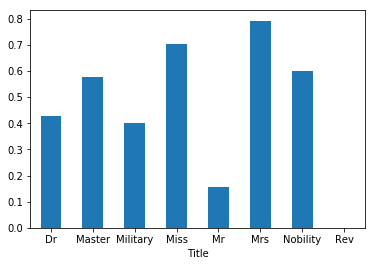

In [6]:
# extract titles from names

# Name format is: Surname, Title. FirstNames
# extract first word after comma, excluding full stop
df['Title']=df.Name.apply(lambda x: x.split(',')[1].strip().split(' ')[0].replace('.',''))

display(df.Title.value_counts())

# strange values
# Jonkheer and Don apparently legitimate nobility titles. 'the' should be Countess.
display(df[(df.Title=='Jonkheer') | (df.Title=='the') | (df.Title=='Don')])
df.Title.replace({'the':'Countess'},inplace=True)

# Group some titles together
df.Title.replace(['Countess', 'Sir', 'Lady', 'Don', 'Jonkheer'],'Nobility',inplace=True)
df.Title.replace(['Major', 'Col', 'Capt'],'Military',inplace=True)
df.Title.replace(['Ms','Mlle','Mme'],'Miss',inplace=True)

display(df.Title.value_counts())

# don't need name column anymore
df.drop('Name',axis=1,inplace=True)

mean_survived('Title').plot.bar(rot=0)

# prefix to sort LabelEncoder in order of survival rate
title_ranks = (mean_survived('Title').sort_values().rank()-1).astype(int)
for title in title_ranks.index:
    df.loc[df.Title==title,'Title'] = str(title_ranks[title])+'_'+title

In [7]:
# categorise fares
print('TICKET TOTAL FARES:')
display(df.groupby('Pclass').Fare.describe())

df['Farepp']=(df.Fare/(df.Tshare+1))
print('FARES PER PERSON:')
display(df.groupby('Pclass').Farepp.describe())

# bin fare in to quantiles for each class
for pclass in df.Pclass.unique():
    # total ticket fare
    fares = df.loc[df.Pclass==pclass,'Fare']
    df.loc[df.Pclass==pclass,'Faretot'] = pd.qcut(fares,3,labels=['0_low','1_mid','2_high'])
    
    # fare per person sharing ticket
    tshare = df.loc[df.Pclass==pclass,'Tshare']
    df.loc[df.Pclass==pclass,'Farepp'] = pd.qcut(fares/(tshare+1),3,labels=['0_low','1_mid','2_high']) 
    # prefixes for LabelEncoder order later
    
df.drop('Fare',axis=1,inplace=True)

df.head(10)

TICKET TOTAL FARES:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


FARES PER PERSON:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,43.650347,30.322236,0.0,26.55,35.2500,50.660392,221.7792
2,184.0,13.322599,5.648278,0.0,10.50,13.0000,13.858658,32.5000
3,491.0,8.085857,2.393923,0.0,7.25,7.8542,8.050000,22.5250


,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Tshare,Title,Farepp,Faretot
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,Unknown,S,0,1_Mr,0_low,0_low
2,1,1,female,38.0,1,0,C,C,0,7_Mrs,2_high,1_mid
3,1,3,female,26.0,0,0,Unknown,S,0,6_Miss,1_mid,1_mid
4,1,1,female,35.0,1,0,C,S,1,7_Mrs,0_low,1_mid
138,0,1,male,37.0,1,0,C,S,1,1_Mr,0_low,1_mid
5,0,3,male,35.0,0,0,Unknown,S,0,1_Mr,2_high,1_mid
6,0,3,male,NaN,0,0,Unknown,Q,0,1_Mr,2_high,1_mid
7,0,1,male,54.0,0,0,E,S,0,1_Mr,2_high,1_mid
8,0,3,male,2.0,3,1,Unknown,S,3,4_Master,0_low,2_high


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

5_Adult          263
4_Young Adult    188
6_Middle-Aged    128
3_Teenager        42
2_Child           24
0_Baby            24
1_Infant          23
7_Senior          22
Name: Age, dtype: int64

Title       Age          
0_Rev       6_Middle-Aged      4
            5_Adult            2
1_Mr        5_Adult          167
            4_Young Adult    120
            6_Middle-Aged     71
            3_Teenager        21
            7_Senior          18
            2_Child            1
2_Military  6_Middle-Aged      4
            7_Senior           1
3_Dr        6_Middle-Aged      4
            4_Young Adult      1
            5_Adult            1
4_Master    0_Baby            14
            2_Child           12
            1_Infant          10
5_Nobility  5_Adult            3
            6_Middle-Aged      2
6_Miss      4_Young Adult     49
            5_Adult           40
            3_Teenager        17
            1_Infant          13
            2_Child           11
            0_Baby            10
            6_Middle-Aged      9
            7_Senior           1
7_Mrs       5_Adult           50
            6_Middle-Aged     34
            4_Young Adult     18
            3_Tee

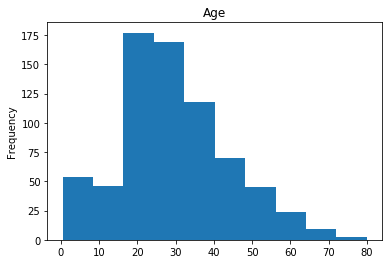

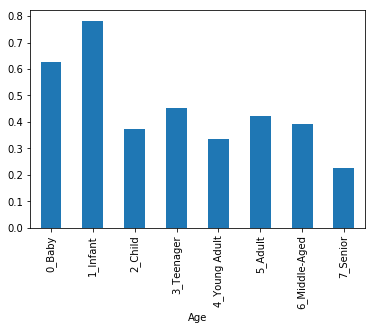

In [8]:
# categorise ages
display(df.Age.describe())
df.Age.plot.hist(title='Age')

#baby 0,1,2
#toddler 2,3
#infant 4,5,6
#child 7-12
#teen 13-17
#adult 18-30
#mature 31-50
#middle-aged 51-65
#pensioner 66+

df['Age'] = pd.cut(df.Age,
                   [-1,2,6,13,17,25,40,60,200],
                   labels=['0_Baby','1_Infant','2_Child','3_Teenager','4_Young Adult','5_Adult','6_Middle-Aged','7_Senior'])
                            # prefixes to give correct order for LabelEncoder later

display(df.Age.value_counts())
display(df.groupby('Title').Age.value_counts())
plt.figure()
mean_survived('Age').plot.bar()

In [9]:
# passengers with NaN age
age_null = df[df.Age.isnull()].index

# columns to compare based on equivalence
cols_equal = ['Survived','Pclass','Sex','Title']
# columns to compare based on both>0 or not
cols_gr0 = ['SibSp','Parch']

for PassengerId in age_null:
    passenger = df.loc[PassengerId]
    matches = df.copy()
    
    # select rows in df that match features of passenger
    for col in cols_equal:
        matches = matches[matches[col]==passenger[col]]

    for col in cols_gr0:
        matches = matches[(matches[col]>0)==(passenger[col]>0)]
    
    # assign most common age in this group to the passenger
    df.loc[PassengerId,'Age']=matches.Age.value_counts().idxmax()

display(df.Age.value_counts())

5_Adult          309
4_Young Adult    285
6_Middle-Aged    146
3_Teenager        42
2_Child           33
7_Senior          26
1_Infant          26
0_Baby            24
Name: Age, dtype: int64

In [10]:
# convert to appropriate format for sklearn
from sklearn import preprocessing

# label encoder
le = preprocessing.LabelEncoder()

# columns to transform to ints
transform_cols = ['Sex','Age','Cabin','Embarked','Title','Farepp','Faretot']


col_classes = dict()
for col in transform_cols:
    df[col] = le.fit_transform(df[col])
    col_classes[col] = le.classes_
    print(col,':',col_classes[col].tolist())

display(df.head(10))

Sex : ['female', 'male']
Age : ['0_Baby', '1_Infant', '2_Child', '3_Teenager', '4_Young Adult', '5_Adult', '6_Middle-Aged', '7_Senior']
Cabin : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Unknown']
Embarked : ['C', 'Q', 'S']
Title : ['0_Rev', '1_Mr', '2_Military', '3_Dr', '4_Master', '5_Nobility', '6_Miss', '7_Mrs']
Farepp : ['0_low', '1_mid', '2_high']
Faretot : ['0_low', '1_mid', '2_high']


,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Tshare,Title,Farepp,Faretot
PassengerId,,,,,,,,,,,,
1,0,3,1,4,1,0,8,2,0,1,0,0
2,1,1,0,5,1,0,2,0,0,7,2,1
3,1,3,0,5,0,0,8,2,0,6,1,1
4,1,1,0,5,1,0,2,2,1,7,0,1
138,0,1,1,5,1,0,2,2,1,1,0,1
5,0,3,1,5,0,0,8,2,0,1,2,1
6,0,3,1,4,0,0,8,1,0,1,2,1
7,0,1,1,6,0,0,4,2,0,1,2,1
8,0,3,1,0,3,1,8,2,3,4,0,2


In [11]:
# create train and test datasets
from sklearn.model_selection import train_test_split

X = df.drop('Survived',axis=1)
y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print('TRAIN: X =',X_train.shape, ', y =',y_train.shape)
print('TEST: X =',X_test.shape, ', y =',y_test.shape)

TRAIN: X = (712, 11) , y = (712,)
TEST: X = (179, 11) , y = (179,)


In [29]:
# decision tree
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=5,random_state=42)
clf=clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
test_score=clf.score(X_test,y_test)
train_score=clf.score(X_train,y_train)

print('Train score:',train_score)
print('Test score:',test_score)

Train score: 0.865168539326
Test score: 0.793296089385


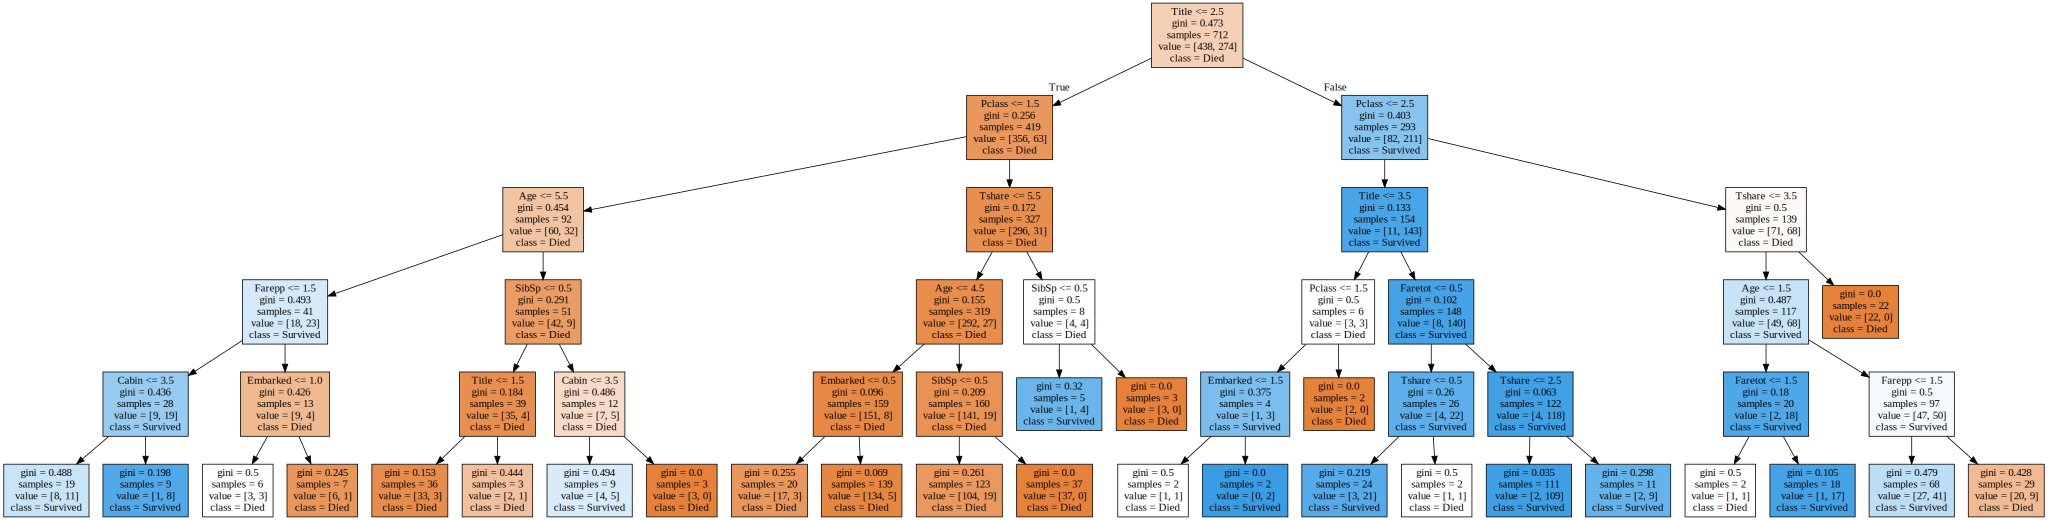

In [30]:
import graphviz

tree.export_graphviz(clf,out_file='tree.dot',feature_names=X.columns,class_names=['Died','Survived'],filled=True)

with open('tree.dot') as f:
    dot_graph=f.read()

graphviz.Source(dot_graph)